# Import Packages

In [1]:
from utils import draw_results

import mne
from mne.time_frequency import tfr_morlet
from mne.stats import spatio_temporal_cluster_1samp_test
from mne.channels import find_ch_adjacency

import scipy
import numpy as np
from scipy.stats import trim_mean
import matplotlib.pyplot as plt
import matplotlib
from pylab import mpl
import dill

In [2]:
plt.rcParams['font.family']=['Arial','serif', 'Times New Roman']
plt.style.use('default')
mpl.rcParams["axes.unicode_minus"] = False
%config InlineBackend.figure_format = 'svg'

# Load Data

In [3]:
# Frequency Bands
# Delta（0-4Hz）
# Theta（4-8Hz）
# Alpha（8-13Hz）
# Beta（13-30Hz）
# Gamma（30-45Hz）

min_freq = 4
max_freq = 30
num_frex = 20 

freqs = np.logspace(*np.log10([min_freq, max_freq]), num=num_frex)
num_frex = len(freqs)

n_cycles = np.logspace(*np.log10([1.0, 3.0]), num=num_frex)

In [4]:
# [symbols*sizes obs freqs times chs]
tfr_data = np.zeros((6, 24, 20, 501, 61)) # total power
evoked_data = np.zeros((6, 24, 20, 501, 61)) # evoked power
induced_data = np.zeros((6, 24, 20, 501, 61)) # induced power
itc_data = np.zeros((6, 24, 20, 501, 61)) # ITPC data

trim = lambda x: trim_mean(x, 0.15, axis=0)  

file_path = "../Data/EEG/Subject_"

for subject in range(1, 25):

    file = file_path + str(subject) + '_epo.fif'        
    epochs = mne.read_epochs(file, preload=True)
    subject -= 1

    events_dict = { }
    for sym in ['pic', 'icon', 'text']: # 3 symbol types
        for size in ['s', 'b']: # 2 conceptual sizes
            events_dict[sym+str(size)] = []

    for id in epochs.event_id:
        # id : ab-cd-e-f-ghi
        # a : symbol type of first stimulus (1 for picture, 2 for icon, 3 for text)
        # b : concept of first stimulus (1-6 for scooter-train)
        # c : symbol type of second stimulus (1 for picture, 2 for icon, 3 for text)
        # d : concept of second stimulus (1-6 for scooter-train)

        small = ['1', '2', '3']
        big = ['4', '5', '6']

        if id[0] == '1' and id[1] in small:
            events_dict['pics'].append(id)
        if id[0] == '1' and id[1] in big:
            events_dict['picb'].append(id)
        
        if id[0] == '2' and id[1] in small:
            events_dict['icons'].append(id)
        if id[0] == '2' and id[1] in big:
            events_dict['iconb'].append(id)
        
        if id[0] == '3' and id[1] in small:
            events_dict['texts'].append(id)
        if id[0] == '3' and id[1] in big:
            events_dict['textb'].append(id)

    epo_list = [ epochs[events_dict['pics']], epochs[events_dict['picb']], 
                epochs[events_dict['icons']], epochs[events_dict['iconb']], 
                epochs[events_dict['texts']], epochs[events_dict['textb']] ]

    for ind, epo in enumerate(epo_list):
        # total power
        tfr, itc = tfr_morlet(epo, freqs=freqs, n_cycles=n_cycles, 
                        use_fft=True, return_itc=True, 
                        average=True, n_jobs=-1)
        tfr.apply_baseline(mode='logratio', baseline = (-0.4, -0.1)).crop(0.0, None);
        itc.crop(0.0, None); 

        # induced power
        evk = epo.average(method=trim)
        induced = epo.subtract_evoked(evk)
        ind_tfr = tfr_morlet(induced, freqs=freqs, n_cycles=n_cycles,
                        use_fft=True, return_itc=False, 
                        average=True, n_jobs=-1)
        ind_tfr.apply_baseline(mode='logratio', baseline = (-0.4, -0.1)).crop(0.0, None);
        
        # evoked power
        evk_tfr = tfr - ind_tfr

        # get power data and ITPC data
        tfr_data[ind, subject] = 10.0 * np.transpose(tfr.data, (1, 2, 0)) # convert logratio to db
        induced_data[ind, subject] = 10.0 * np.transpose(ind_tfr.data, (1, 2, 0)) # convert logratio to db
        evoked_data[ind, subject] = 10.0 * np.transpose(evk_tfr.data, (1, 2, 0)) # convert logratio to db        
        itc_data[ind, subject] = np.transpose(itc.data, (1, 2, 0))

Reading e:\论文写作\论文1最终投稿\实验数据与分析脚本\Scripts\..\Data\EEG\Subject_1_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
370 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    2.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    2.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    2.4s finished


[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Reading e:\论文写作\论文1最终投稿\实验数据与分析脚本\Scripts\..\Data\EEG\Subject_2_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
399 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Reading e:\论文写作\论文1最终投稿\实验数据与分析脚本\Scripts\..\Data\EEG\Subject_3_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished


308 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Reading e:\论文写作\论文1最终投稿\实验数据与分析脚本\Scripts\..\Data\EEG\Subject_4_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished


Not setting metadata
398 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished


Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Reading e:\论文写作\论文1最终投稿\实验数据与分析脚本\Scripts\..\Data\EEG\Subject_5_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
379 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Reading e:\论文写作\论文1最终投稿\实验数据与分析脚本\Scripts\..\Data\EEG\Subject_6_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished


Not setting metadata
359 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Reading e:\论文写作\论文1最终投稿\实验数据与分析脚本\Scripts\..\Data\EEG\Subject_7_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished


Not setting metadata
397 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Reading e:\论文写作\论文1最终投稿\实验数据与分析脚本\Scripts\..\Data\EEG\Subject_8_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
408 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Reading e:\论文写作\论文1最终投稿\实验数据与分析脚本\Scripts\..\Data\EEG\Subject_9_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
284 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Reading e:\论文写作\论文1最终投稿\实验数据与分析脚本\Scripts\..\Data\EEG\Subject_10_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished


Not setting metadata
426 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Reading e:\论文写作\论文1最终投稿\实验数据与分析脚本\Scripts\..\Data\EEG\Subject_11_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
302 matching events found
No baseline correction applied


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished


0 projection items activated
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Reading e:\论文写作\论文1最终投稿\实验数据与分析脚本\Scripts\..\Data\EEG\Subject_12_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished


Not setting metadata
357 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished


Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Reading e:\论文写作\论文1最终投稿\实验数据与分析脚本\Scripts\..\Data\EEG\Subject_13_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished


390 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Reading e:\论文写作\论文1最终投稿\实验数据与分析脚本\Scripts\..\Data\EEG\Subject_14_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished


Not setting metadata
358 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished


Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Reading e:\论文写作\论文1最终投稿\实验数据与分析脚本\Scripts\..\Data\EEG\Subject_15_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished


Not setting metadata
356 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Reading e:\论文写作\论文1最终投稿\实验数据与分析脚本\Scripts\..\Data\EEG\Subject_16_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished


Not setting metadata
426 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Reading e:\论文写作\论文1最终投稿\实验数据与分析脚本\Scripts\..\Data\EEG\Subject_17_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
385 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished


Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Reading e:\论文写作\论文1最终投稿\实验数据与分析脚本\Scripts\..\Data\EEG\Subject_18_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished


Not setting metadata
366 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.2s remaining:    0.0s


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)


[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished


Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Reading e:\论文写作\论文1最终投稿\实验数据与分析脚本\Scripts\..\Data\EEG\Subject_19_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished


376 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Reading e:\论文写作\论文1最终投稿\实验数据与分析脚本\Scripts\..\Data\EEG\Subject_20_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s


Applying baseline correction (mode: logratio)
Reading e:\论文写作\论文1最终投稿\实验数据与分析脚本\Scripts\..\Data\EEG\Subject_21_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
322 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Reading e:\论文写作\论文1最终投稿\实验数据与分析脚本\Scripts\..\Data\EEG\Subject_22_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
383 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished


Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Reading e:\论文写作\论文1最终投稿\实验数据与分析脚本\Scripts\..\Data\EEG\Subject_23_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished


293 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.0s finished


Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s


Applying baseline correction (mode: logratio)
Reading e:\论文写作\论文1最终投稿\实验数据与分析脚本\Scripts\..\Data\EEG\Subject_24_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
346 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished


Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)
Subtracting Evoked from Epochs
[done]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=-1)]: Done  43 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  56 out of  61 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    0.1s finished


# Calculate Adjacency Matrix

In [5]:
epo = mne.read_epochs("../Data/EEG/Subject_1_epo.fif", preload=True);
epo.crop(0.0, 1.0);

sensor_adjacency, ch_names = find_ch_adjacency(epo.info, ch_type="eeg")

adjacency = mne.stats.combine_adjacency(
    num_frex,
    len(epo.times),
    sensor_adjacency,
) # shape : [channels * freqs * times]

Reading e:\论文写作\论文1最终投稿\实验数据与分析脚本\Scripts\..\Data\EEG\Subject_1_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
370 matching events found
No baseline correction applied
0 projection items activated
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 61


# Cluster Level Permutation ttest in Picture

In [6]:
pval = 0.05  # threshold of p-value
df = 24 - 1  # degrees of freedom for the test (n_observations - 1)
t_thresh_min = scipy.stats.t.ppf(1 - pval / 2, df)  # two-tailed, t distribution

print(t_thresh_min)

2.0686576104190406


In [7]:
import dill
with open('./three_symbols_small_big_tfr_itc_t_stats.pkl', 'rb') as f:
    [p_tfr, i_tfr, t_tfr, p_itc, i_itc, t_itc,
     p_evk, i_evk, t_evk, p_ind, i_ind, t_ind, ] = dill.load(f)

## Evoked Power

In [94]:
X = evoked_data[0] - evoked_data[1]

t_thresh = 3.7 # must larger than t_thresh_min(2.069)

print(t_thresh)

p_evk = T_obs, clusters, cluster_p_values, H0 = spatio_temporal_cluster_1samp_test(
    X,
    threshold=t_thresh,
    n_permutations=3000,
    adjacency=adjacency,
    n_jobs=30,
    buffer_size=1024,
    verbose=True,)

good_clusters_idx = np.where(cluster_p_values < 0.05)[0]
good_clusters = [clusters[idx] for idx in good_clusters_idx]
print(len(good_clusters))
print(good_clusters_idx)

3.7
stat_fun(H1): min=-6.151969 max=5.170095
Running initial clustering …
Found 35 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

5
[ 0  1  2  3 11]


In [22]:
p_evk_merge = p_evk

# 合并簇0和簇3，将簇3的p-value值设为不显著
p_evk_merge[2][3] = 0.9
p_evk_merge[1][0] = ( np.hstack((p_evk_merge[1][0][0],p_evk_merge[1][3][0])),
                        np.hstack((p_evk_merge[1][0][1],p_evk_merge[1][3][1])),
                        np.hstack((p_evk_merge[1][0][2],p_evk_merge[1][3][2])) )

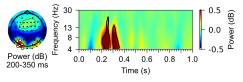

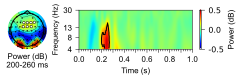

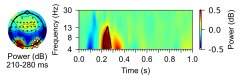

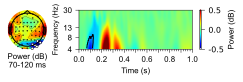

In [23]:
draw_results.draw_tf_diff_clusters(p_evk_merge, [evoked_data[0], evoked_data[1]], epo, figsize=(3.5,2.5),
                                    title='', cbunit="Power (dB)",
                                    vmin=-0.5, vmax=0.5, cmap='jet', cbar_ticks=[-0.5, 0.0, 0.5])

## ITPC

In [9]:
X = itc_data[0] - itc_data[1] 

t_thresh = 3.1 # must larger than t_thresh_min(2.069)
print(t_thresh)

p_itc = T_obs, clusters, cluster_p_values, H0 = spatio_temporal_cluster_1samp_test(
    X,
    threshold=t_thresh,
    n_permutations=3000,
    adjacency=adjacency,
    n_jobs=30,
    buffer_size=1024,
    verbose=True,)

good_clusters_idx = np.where(cluster_p_values < 0.05)[0]
good_clusters = [clusters[idx] for idx in good_clusters_idx]
print(len(good_clusters))
print(good_clusters_idx)

3.1
stat_fun(H1): min=-5.913110319352031 max=6.652518619213972
Running initial clustering …
Found 242 clusters


  0%|          | Permuting : 0/2999 [00:00<?,       ?it/s]

3
[  6   7 149]


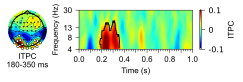

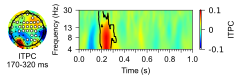

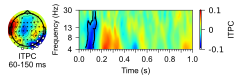

In [13]:
draw_results.draw_tf_diff_clusters(p_itc, [itc_data[0], itc_data[1]], epo, figsize=(3.5,2.5),
                                title='', cbunit='ITPC', #ITPC differences between different conceptual size
                                vmin=-0.1, vmax=0.1, cmap='jet', cbar_ticks=[-0.1, 0, 0.1]) 

# Cluster Level Permutation ttest in Icon

## Evoked Power

In [10]:
X = evoked_data[2] - evoked_data[3] 

t_thresh = 3.5 # must larger than t_thresh_min(2.069)
print(t_thresh)

i_evk = T_obs, clusters, cluster_p_values, H0 = spatio_temporal_cluster_1samp_test(
    X,
    threshold=t_thresh,
    n_permutations=3000,
    adjacency=adjacency,
    n_jobs=30,
    buffer_size=1024,
    verbose=True,)

good_clusters_idx = np.where(cluster_p_values < 0.05)[0]
good_clusters = [clusters[idx] for idx in good_clusters_idx]
print(len(good_clusters))
print(good_clusters_idx)

3.5
stat_fun(H1): min=-6.132797971130374 max=4.016251916320497
Running initial clustering …
Found 37 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

1
[9]


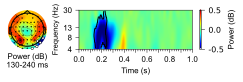

In [11]:
# import importlib
# importlib.reload(draw_results)

draw_results.draw_tf_diff_clusters(i_evk, [evoked_data[2], evoked_data[3]], epo, figsize=(3.5,2.5), 
                                title='', cbunit='Power (dB)', 
                                vmin=-0.5, vmax=0.5, cmap='jet', cbar_ticks=[-0.5,0.0,0.5])

## ITPC

In [18]:
X = itc_data[2] - itc_data[3] 

t_thresh = 3.2 # must larger than t_thresh_min(2.069)
print(t_thresh)

i_itc = T_obs, clusters, cluster_p_values, H0 = spatio_temporal_cluster_1samp_test(
    X,
    threshold=t_thresh,
    n_permutations=3000,
    adjacency=adjacency,
    n_jobs=30,
    buffer_size=1024,
    verbose=True,)

good_clusters_idx = np.where(cluster_p_values < 0.05)[0]
good_clusters = [clusters[idx] for idx in good_clusters_idx]
print(len(good_clusters))
print(good_clusters_idx)

3.2
stat_fun(H1): min=-6.918198646515349 max=4.891930169690409
Running initial clustering …
Found 215 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

2
[101 102]


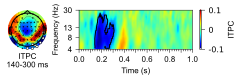

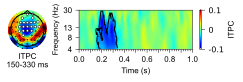

In [19]:
draw_results.draw_tf_diff_clusters(i_itc, [itc_data[2], itc_data[3]], epo, figsize=(3.5,2.5),
                                title='', cbunit='ITPC',
                                vmin=-0.10, vmax=0.10, cmap='jet', cbar_ticks=[-0.1,0,0.1])

# Cluster Level Permutation ttest in Text

## Evoked Power

In [36]:
X = evoked_data[4] - evoked_data[5] 

t_thresh = 2.0 # must larger than t_thresh_min(2.069)
print(t_thresh)

t_evk = T_obs, clusters, cluster_p_values, H0 = spatio_temporal_cluster_1samp_test(
    X,
    threshold=t_thresh,
    n_permutations=3000,
    adjacency=adjacency,
    n_jobs=30,
    buffer_size=1024,
    verbose=True,)

good_clusters_idx = np.where(cluster_p_values < 0.05)[0]
good_clusters = [clusters[idx] for idx in good_clusters_idx]
print(len(good_clusters))
print(good_clusters_idx)

2.0
stat_fun(H1): min=-4.495379 max=4.916268
Running initial clustering …
Found 212 clusters


  0%|          | Permuting : 0/499 [00:00<?,       ?it/s]

0
[]


## ITPC

In [16]:
X = itc_data[4] - itc_data[5] 

t_thresh = 1.0
print(t_thresh)

t_itc = T_obs, clusters, cluster_p_values, H0 = spatio_temporal_cluster_1samp_test(
    X,
    threshold=t_thresh,
    n_permutations=3000,
    adjacency=adjacency,
    n_jobs=30,
    buffer_size=1024,
    verbose=True,)

good_clusters_idx = np.where(cluster_p_values < 0.05)[0]
good_clusters = [clusters[idx] for idx in good_clusters_idx]
print(len(good_clusters))
print(good_clusters_idx)

1.0
stat_fun(H1): min=-5.998836 max=5.541710
Running initial clustering …
Found 558 clusters


  0%|          | Permuting : 0/499 [00:00<?,       ?it/s]

0
[]


In [12]:
import dill
with open('./three_symbols_small_big_tfr_itc_t_stats.pkl', 'wb') as f:
    dill.dump([p_tfr, i_tfr, t_tfr, p_itc, i_itc, t_itc,
     p_evk, i_evk, t_evk, p_ind, i_ind, t_ind, ], f)